# Package Usage Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

from Multi-Layer-Kernel-Machine.Mydataset import mydataset
from Multi-Layer-Kernel-Machine.RandomFeature import RandomFourierFeature
from Multi-Layer-Kernel-Machine.Fitting import MultilayerFitting
from Multi-Layer-Kernel-Machine.Structure import Net,ResNet,KernelNet,ResKernelNet
from Multi-Layer-Kernel-Machine.DataSplitting import DataSplitting
from Multi-Layer-Kernel-Machine.GenerateSplit import GenerateSplit

In [12]:
##### example
df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
#smaller dataset
train=df.iloc[300000:300700] 
test=df.iloc[500000:500300] 
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:700]
test_x=x.iloc[700:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,-1.169588,-0.913331,-1.303357,0.366642,-1.446675,-0.408470,0.866105,0.914454,-1.242843,-0.667838,...,0.207254,0.352000,-1.993373,-0.121706,-0.624721,-3.186580,2.233731,-1.497663,1.015620,1.535324
1,-0.384652,0.083956,-0.409324,0.340569,-0.922879,0.015633,1.158662,0.921513,0.571624,0.059751,...,2.548116,1.116907,-0.863423,-1.574714,1.571018,0.933343,-0.660936,0.018256,-0.441595,0.061384
2,-0.474117,1.071657,-2.011545,1.578102,-0.387551,0.668625,1.009691,-1.046157,0.164916,0.055518,...,-0.107606,-4.416389,6.454818,3.133579,4.412800,-6.273857,-2.294102,6.551096,-0.142954,-0.990494
3,-1.085627,1.033851,-1.001179,2.001694,0.231899,1.523338,1.051318,1.507985,-0.941449,-0.231110,...,0.101883,3.043570,1.424674,-1.320191,1.222839,0.278665,2.211740,0.589111,-2.269302,1.055646
4,-0.705294,-0.778753,-2.057925,-0.842471,0.976928,-0.353554,-0.405709,0.509083,0.569620,-0.519164,...,-1.579429,0.847409,-1.423293,0.122463,-0.858162,-1.384214,0.440914,-1.079154,-0.234252,0.420268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,-1.448799,0.325952,0.582353,0.258919,0.149646,-0.474193,-1.217127,-0.916761,0.088114,-0.320500,...,0.175976,-0.362254,-1.443022,-0.329998,-0.809020,-0.096618,-1.097373,1.158430,-0.030136,-0.139725
696,-0.743319,0.679493,-0.121131,0.266191,0.153593,0.116883,0.285190,0.262373,0.744065,1.012218,...,0.336759,-0.120216,-0.228381,-0.525685,0.470486,-0.179525,-0.485096,-0.265838,-0.166360,-0.097013
697,-1.079830,0.074670,-0.605215,-0.890968,0.940719,-0.745934,-2.093624,-0.008216,1.374812,1.199631,...,0.253918,0.084684,-0.654068,-0.514407,-0.104413,0.146940,-0.811716,0.178947,0.876225,0.210794
698,-0.628019,0.188730,0.035737,-0.332677,0.625774,-0.682705,0.116143,-0.111752,1.780001,0.683753,...,1.043273,0.018961,-0.808076,0.129063,-0.854428,0.051633,0.294883,0.436294,-0.226600,2.013739


In [13]:
##### data
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())
    
    
batch=100
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=batch, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=batch, shuffle=False)

## Multilayer Structure

In [14]:
##### DNN example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net([90,32,8,1],device) 
print(net)
torch.manual_seed(0)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
dnn_trainloss,dnn_testloss,dnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y, batch)
#mlmodel.Bootstrap(40,dnn_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3984438.0
                    Test  set - loss: 4001260.5
                    
epoch 100
                    Train set - loss: 399.58258056640625
                    Test  set - loss: 2541.88427734375
                    
epoch 200
                    Train set - loss: 151.03475952148438
                    Test  set - loss: 915.9685668945312
                    
epoch 300
                    Train set - loss: 84.96205139160156
                    Test  set - loss: 690.5421752929688
                    
epoch 400
                    Train set - loss: 58.495849609375
                    Test  set - loss: 630.4786987304688
                    
epoch 500
                    Train set - loss: 59.734176635

In [15]:
##### ResNet example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet([90,32,8,1],device)
print(net)
torch.manual_seed(0)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-7,momentum=0.9,weight_decay=1e-2)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 4000, criterion, optimizer,100,100)
res_trainloss,res_testloss,res_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y, batch)
#mlmodel.Bootstrap(40,res_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

ResNet(
  (layers): ModuleList(
    (0): ResidualBlock1(
      (fc1): Linear(in_features=90, out_features=32, bias=True)
      (fc2): Linear(in_features=90, out_features=32, bias=True)
    )
    (1): ResidualBlock1(
      (fc1): Linear(in_features=32, out_features=8, bias=True)
      (fc2): Linear(in_features=32, out_features=8, bias=True)
    )
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3977215.0
                    Test  set - loss: 4000395.25
                    
epoch 100
                    Train set - loss: 3124.539794921875
                    Test  set - loss: 11475.6611328125
                    
epoch 200
                    Train set - loss: 886.2252197265625
                    Test  set - loss: 4481.39892578125
                    
epoch 300
                    Train set - loss: 388.1315612792969
                    Test  set - loss: 2702.1875
                    
epoch 400
                    Train set - l

In [16]:
##### MLK example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
kernelnn_trainloss,kernelnn_testloss,kernelnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y, batch)
#mlmodel.Bootstrap(40,kernelnn_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

KernelNet(
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3786689.5
                    Test  set - loss: 3730715.75
                    
epoch 100
                    Train set - loss: 505.8685302734375
                    Test  set - loss: 1707.318115234375
                    
epoch 200
                    Train set - loss: 264.5469055175781
                    Test  set - loss: 740.8114013671875
                    
epoch 300
                    Train set - loss: 143.6947784423828
                    Test  set - loss: 410.0532531738281
                    
epoch 400
                    Train set - loss: 132.98013305664062
                    Test  set - loss: 269.2728271484375
                    
epoch 500
                    Train set - loss: 120.90164184570312
                    Test  set - loss: 205.16761779785156
                   

In [17]:
### RK example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResKernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-7,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100)
reskernel_trainloss,reskernel_testloss,reskernel_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y, batch)
#mlmodel.Bootstrap(40,reskernel_bootbase,train_x,train_y,test_x,test_y, batch,init_weights)

ResKernelNet(
  (layers): ModuleList(
    (0): ResidualBlock2(
      (fc1): Linear(in_features=32, out_features=8, bias=True)
      (fc2): Linear(in_features=8, out_features=8, bias=True)
    )
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)
epoch 0
                    Train set - loss: 3972457.0
                    Test  set - loss: 3998881.5
                    
epoch 100
                    Train set - loss: 756.9252319335938
                    Test  set - loss: 396.6432800292969
                    
epoch 200
                    Train set - loss: 253.99658203125
                    Test  set - loss: 159.12945556640625
                    
epoch 300
                    Train set - loss: 232.8259735107422
                    Test  set - loss: 115.39389038085938
                    
epoch 400
                    Train set - loss: 132.8750457763672
                    Test  set - loss: 99.2923355102539
                    
epoch 500
                    Train set - loss

In [18]:
### single layer example
model =Ridge(alpha=1)
score=[]
trainmse=[]
testmse=[]
gaset=np.linspace(0,0.3,10)
for ga in gaset:
    rff=RandomFourierFeature(90,100,kernel='G',gamma=ga,device="cpu")
    train_xtransformed=rff.transform(nntrain_x)
    test_xtransformed=rff.transform(nntest_x)
    model.fit(train_xtransformed, nntrain_y)
    y_pretest=model.predict(test_xtransformed)
    y_pretrain=model.predict(train_xtransformed)
    score.append(cross_val_score(model,train_xtransformed,train_y,cv=5).mean())   ##cross-validation
    trainmse.append(mean_squared_error(y_pretrain,train_y))
    testmse.append(mean_squared_error(y_pretest,test_y))
ind=score.index(max(score))
print("cv-score,index,gamma,trainmse,testmse",max(score),ind,gaset[ind],trainmse[ind],testmse[ind])

cv-score,index,gamma,trainmse,testmse -0.7439196093744125 5 0.16666666666666666 80.503634381025 179.2198970316389


estimation

In [19]:
##### MLK interval example
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
print(net)
torch.manual_seed(1)
net.apply(init_weights)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=8e-4,momentum=0.9,weight_decay=1e-4) #optim.Adam(...)
mlmodel=MultilayerFitting(net,device,train_loader, test_loader, 2000, criterion, optimizer,100,100,printchoice=False)
kernelnn_trainloss,kernelnn_testloss,kernelnn_bootbase=mlmodel.fitting(train_x,train_y,test_x,test_y, batch)

mlmodel.GradientBand(kernelnn_trainloss,train_x,train_y,test_x,test_y, batch)
mlmodel.HomoConformalBand(train_x,train_y,test_x,test_y, batch)
mlmodel.HeteConformalBand(kernelnn_trainloss,train_x,train_y,test_x,test_y, batch)

KernelNet(
  (layers): ModuleList(
    (0): Linear(in_features=32, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=1, bias=True)
  )
)


100%|██████████| 700/700 [00:00<00:00, 1363.70it/s]


torch.Size([700, 273])


100%|██████████| 300/300 [00:00<00:00, 1171.51it/s]


n-p: 427  mark: 300
length 60.59107279674412
95 coverage 0.95
666.0
length tensor(45.5708)
95 coverage 0.8533333333333334


100%|██████████| 700/700 [00:00<00:00, 1343.18it/s]


666.0


100%|██████████| 300/300 [00:00<00:00, 1466.87it/s]

length 53.27265082041423
95 coverage 0.9166666666666666


(53.27265082041423, 0.9166666666666666)

comparison

In [20]:
def plot_choose(fig,start,data):
    fig.plot(np.arange(start,len(data)),data[start:])

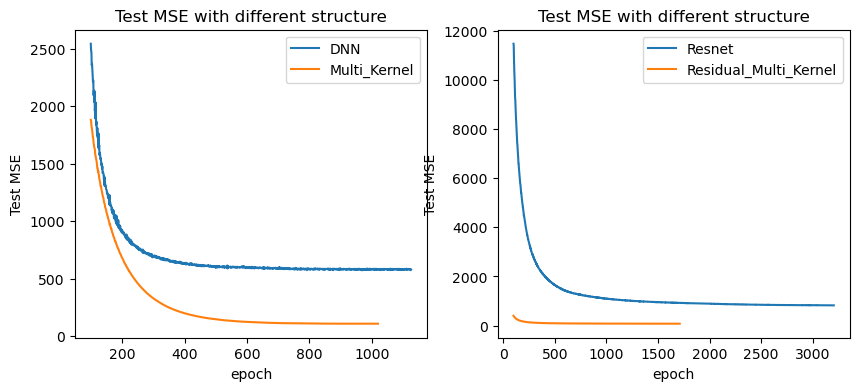

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],100,dnn_testloss)
plot_choose(ax[0],100,kernelnn_testloss)
ax[0].legend(["DNN","Multi_Kernel"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],100,res_testloss)
plot_choose(ax[1],100,reskernel_testloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Test MSE")
ax[1].set_title("Test MSE with different structure")

plt.show()

## data splitting

In [28]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
train_loaderset,netset,optimizerset=GenerateSplit(2,device,net,8e-4,0.9,1e-4,
                                                                       train_x,train_y, batch,init_weights)
criterion=nn.MSELoss()  
split=2  
splkermodel=DataSplitting(split,netset,device,train_loaderset, test_loader, 2000, criterion, optimizerset,100,100,printchoice=True)
splker_trainloss,splker_testloss,splker_prediction=splkermodel.fitting(train_x,train_y,test_x,test_y, batch)

epoch 0
                    Train set - loss: 3774104.0
                    Test  set - loss: 3665505.0
                    
epoch 100
                    Train set - loss: 1367.9190673828125
                    Test  set - loss: 3341.66748046875
                    
epoch 200
                    Train set - loss: 282.01068115234375
                    Test  set - loss: 1190.02294921875
                    
epoch 300
                    Train set - loss: 160.0959930419922
                    Test  set - loss: 495.312255859375
                    
epoch 400
                    Train set - loss: 128.88143920898438
                    Test  set - loss: 257.1908264160156
                    
epoch 500
                    Train set - loss: 113.31652069091797
                    Test  set - loss: 166.12876892089844
                    
epoch 600
                    Train set - loss: 115.92384338378906
                    Test  set - loss: 129.46429443359375
                    
epoch 700
   

In [29]:
splkermodel.GradientBand(splker_trainloss,train_x,train_y,test_x,test_y, batch)

torch.Size([700, 273])
torch.Size([700, 273])
n-p: 427  mark: 300
length 50.26769352913451
95 coverage 0.9066666666666666


(50.26769352913451, 0.9066666666666666)

In [30]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResKernelNet([90,32,8,1],["C","G"],[0.01,0.1],device)
train_loaderset,netset,optimizerset=GenerateSplit(2,device,net,8e-7,0.9,1e-4,
                                                                       train_x,train_y, batch,init_weights)
criterion=nn.MSELoss()    
split=2 
splresmodel=DataSplitting(split,netset,device,train_loaderset, test_loader, 2000, criterion, optimizerset,100,100,printchoice=True)
splres_trainloss,splres_testloss,splres_prediction=splresmodel.fitting(train_x,train_y,test_x,test_y, batch)

epoch 0
                    Train set - loss: 3974928.0
                    Test  set - loss: 3995430.75
                    
epoch 100
                    Train set - loss: 372.3681640625
                    Test  set - loss: 152.97047424316406
                    
epoch 200
                    Train set - loss: 245.17494201660156
                    Test  set - loss: 103.75817108154297
                    
epoch 300
                    Train set - loss: 117.02838134765625
                    Test  set - loss: 93.11450958251953
                    
epoch 400
                    Train set - loss: 142.8675537109375
                    Test  set - loss: 88.73835754394531
                    
epoch 500
                    Train set - loss: 166.29666137695312
                    Test  set - loss: 84.92658233642578
                    
epoch 600
                    Train set - loss: 192.44198608398438
                    Test  set - loss: 82.8881607055664
                    
epoch 700
    

In [31]:
splresmodel.GradientBand(splres_trainloss,train_x,train_y,test_x,test_y, batch)

torch.Size([700, 345])
torch.Size([700, 345])
n-p: 355  mark: 300
length 52.45223505411531
95 coverage 0.9133333333333333


(52.45223505411531, 0.9133333333333333)

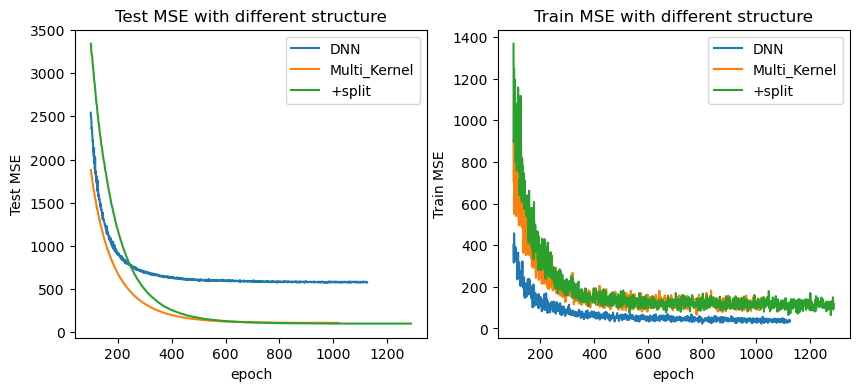

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],100,dnn_testloss)
plot_choose(ax[0],100,kernelnn_testloss)
plot_choose(ax[0],100,splker_testloss)
ax[0].legend(["DNN","Multi_Kernel","+split"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],100,dnn_trainloss)
plot_choose(ax[1],100,kernelnn_trainloss)
plot_choose(ax[1],100,splker_trainloss)
ax[1].legend(["DNN","Multi_Kernel","+split"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()

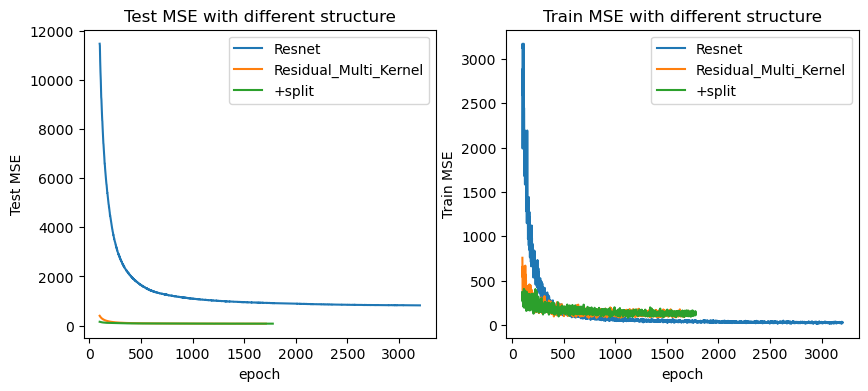

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_choose(ax[0],100,res_testloss)
plot_choose(ax[0],100,reskernel_testloss)
plot_choose(ax[0],100,splres_testloss)
ax[0].legend(["Resnet","Residual_Multi_Kernel","+split"])
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("Test MSE")
ax[0].set_title("Test MSE with different structure")

plot_choose(ax[1],100,res_trainloss)
plot_choose(ax[1],100,reskernel_trainloss)
plot_choose(ax[1],100,splres_trainloss)
ax[1].legend(["Resnet","Residual_Multi_Kernel","+split"])
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("Train MSE")
ax[1].set_title("Train MSE with different structure")
plt.show()